# Samplex Inputs and Outputs

## Introduction

{class}`~.Samplex` is the core type of the samplomatic library.
A samplex represents a parametric probability distribution over the
parameters of some template circuit, as well as other array-valued fields to use in
post-processing data collected from executing the bound template circuit. It
implements a {meth}`~.Samplex.sample` method that draws from this distribution to produce a
collection of arrays that include at least an array of (random) angles valid for the template
circuit. For example, a samplex instance might implement Pauli-twirling of all the layers of some
base circuit including final measurements, so that the angles returned by sampling from it
correspond to Pauli gates composed with whatever single-qubit gates exist in the base circuit,
along with bool arrays that describe how to invert those measurement results flipped by
measurement twirling. 

The arrays supplied to and return from {meth}`~.Samplex.sample` are "strongly typed" in the
sense that for any particular instance of a {class}`~.Samplex`, their names, types, and shapes are both fixed and queryable before any sampling is performed.
It's worth emphasizing that two samplex instances typically have different input and output names, types, and shapes, as these values.
The goal of this guide is to explain how to interact with samplex inputs and outputs.

## Setup

To begin, we construct a boxed-up circuit and build it into a samplex and template pair to use in the examples that follow.
Note the names `alpha`, `beta`, `noise1`, `noise2`, `mod_a`, `mod_b`, `abc`, and `conclude`, and the existence of four `Parameter`s, which will all play a role in the samplex inputs and outputs.

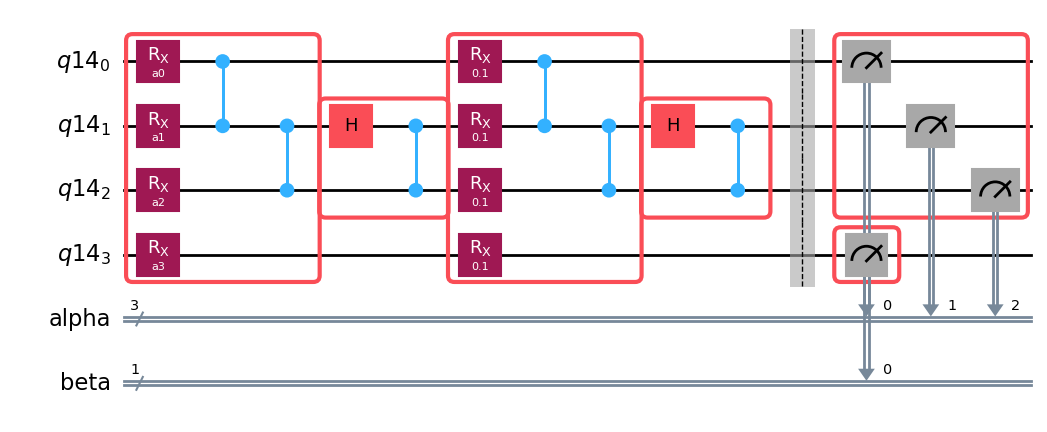

In [33]:
from qiskit.circuit import ClassicalRegister, Parameter, QuantumCircuit, QuantumRegister
from qiskit.quantum_info import PauliLindbladMap

from samplomatic import BasisTransform, InjectNoise, Twirl, build

# our circuit has two classical registers named alpha and beta
circuit = QuantumCircuit(
    QuantumRegister(4), alpha := ClassicalRegister(3, "alpha"), beta := ClassicalRegister(1, "beta")
)

# the first box is only twirled
with circuit.box([Twirl()]):
    for idx in range(4):
        circuit.rx(Parameter(f"a{idx}"), idx)
    circuit.cz(0, 1)
    circuit.cz(1, 2)

# the second box is twirled, and has noise injected
with circuit.box([Twirl(), InjectNoise(ref="noise1", modifier_ref="mod_a")]):
    circuit.h(1)
    circuit.cz(1, 2)

# the third box is twirled, and has different noise injected
with circuit.box([Twirl(), InjectNoise(ref="noise2", modifier_ref="abc")]):
    circuit.rx(0.1, range(4))
    circuit.cz(0, 1)
    circuit.cz(1, 2)

# the fourth box is the same as the second, but with a different modifer ref
with circuit.box([Twirl(), InjectNoise(ref="noise1", modifier_ref="mod_b")]):
    circuit.h(1)
    circuit.cz(1, 2)

circuit.barrier()

# the final two boxes twirl, and add a basis transformation in one case
with circuit.box([Twirl(), BasisTransform(ref="conclude")]):
    circuit.measure(range(3), alpha)

with circuit.box([Twirl()]):
    circuit.measure([3], beta)

circuit.draw("mpl")

This circuit is now built into a template and samplex pair, and we see how each of the boxes is turned into a barrier-sandwich including `rz-sx-rz-sx-rz` fragments to implement dressing.

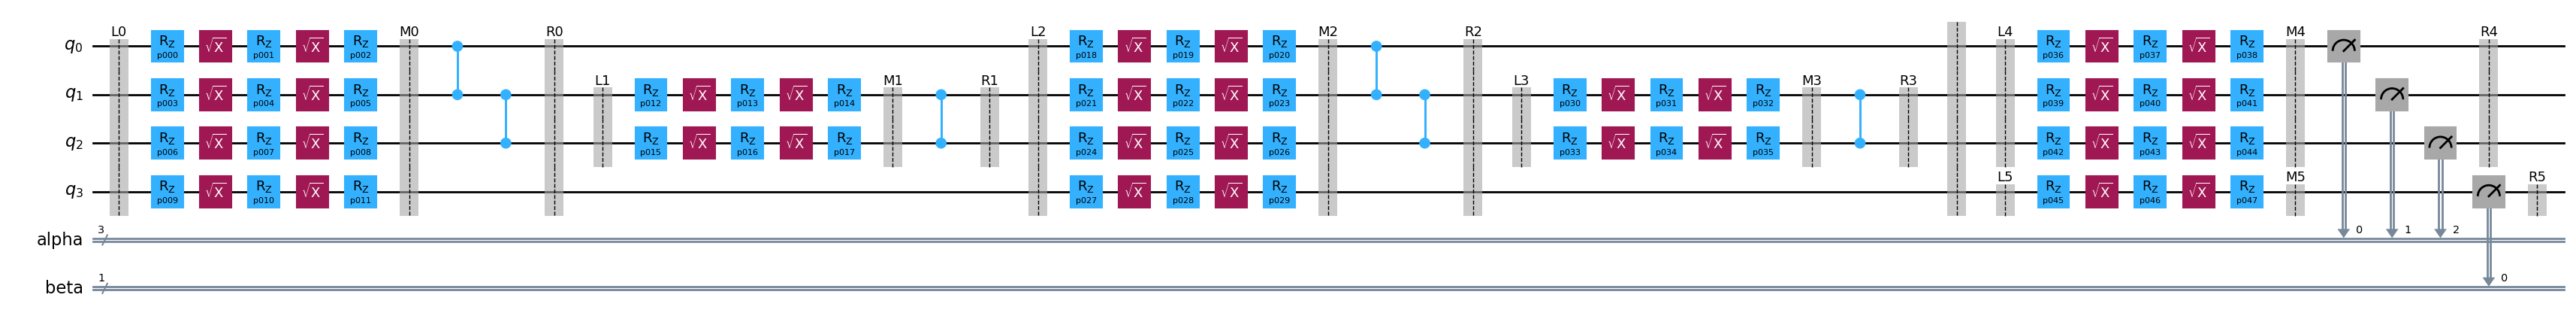

In [34]:
template, samplex = build(circuit)

template.draw("mpl", fold=100)

Plotting the samplex DAG and hovering over the nodes one can see that all of the sampling nodes (stars) are responsible for generating randomizations for twirling, sampling from noise models, or injecting basis changes, and that all of the collection nodes (bow ties) are responsible for rendering slices of outputs, which are either measurement flips or parameter angles.

In [35]:
samplex.draw()

## Querying the required inputs and expected outputs

The easiest way to see the required inputs and expected outputs is to print the {class}`~.Samplex` object. Array items are formatted as `'{name}' <{type}[{shape}...]>` followed by, importantly, whether they are optional or required, and then a description string.

In [36]:
print(samplex)

Samplex(<57 nodes>)
  Inputs:
    * 'basis_changes.conclude' <uint8[3]>: Basis changing gates.
    * 'local_scales.abc' <float64[0]>: (Optional) An array of factors by which to scale
        individual rates of a noise map. The order should match the order of the corresponding
        Pauli list.
    * 'local_scales.mod_a' <float64[0]>: (Optional) An array of factors by which to scale
        individual rates of a noise map. The order should match the order of the corresponding
        Pauli list.
    * 'local_scales.mod_b' <float64[0]>: (Optional) An array of factors by which to scale
        individual rates of a noise map. The order should match the order of the corresponding
        Pauli list.
    * 'noise_maps.rates.noise1' <float64[0]>: The rates of a noise map with 0 terms acting
        on 2 qubits. The order should match the order of the corresponding Pauli list.
    * 'noise_maps.rates.noise2' <float64[0]>: The rates of a noise map with 0 terms acting
        on 4 qubits. Th

If the inputs or outputs need to be queried programatically, the {meth}`~.Samplex.inputs` and {meth}`~.Samplex.outputs` methods can be used.
To have all requisite shape information, the former requires some information about the noise models (if there are any), and the latter requires the number of randomizations.
The return types of both are {class}`~.TensorInterface` instances, though the outputs use the specialization {class}`~.SamplexOutput`.

In [29]:
noise1 = PauliLindbladMap.identity(2).paulis
noise2 = PauliLindbladMap.identity(4)
samplex.inputs({"noise1": noise1, "noise2": noise2})

AttributeError: 'qiskit.quantum_info.PauliLindbladMap' object has no attribute 'paulis'

## Binding input values and sampling



In [37]:
inputs = samplex.inputs({"noise1": noise1, "noise2": noise2}).bind(
    basis_changes={"conclude": ...},
    local_scales={"abc": ..., "mod_a": ..., "mod_b": ...},
    noise_scales={"abc": ..., "mod_a": ..., "mod_b": ...},
    noise_maps={"rates": {"noise1": noise1.rates, "noise2": noise1.rates}},
    parameter_values=[],
)

TypeError: Object is type <class 'qiskit.quantum_info.PauliLindbladMap'> but expected ValueType.PAULIS.